# Ancient Coin Reconstruction

In [1]:
# Import necessary packages
import os
import cv2
import time
import torch
import random
import numpy as np
import pandas as pd
import torch.nn as nn
import seaborn as sns
import scipy.ndimage as ndi
import torch.optim as optim
from collections import Counter
from torchvision import transforms
from torch.autograd import Variable
from matplotlib import pyplot as plt
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision.utils import save_image

### Prepare Dataset

In [2]:
# Define a function to prepare the dataset
def dataset(path):
    # Load the dataset info
    df = pd.read_csv('../data/query.csv')[['RecordId', 'Denomination']]

    # Create an empty dataframe to store the dataset
    data = pd.DataFrame(columns=['images', 'denomination'])

    # Get all subfolders
    for folder in os.listdir(path):
        # Find denomination
        idx = np.where(df['RecordId'] == folder)[0][0]
        d = df['Denomination'][idx]

        # Get all images files
        for filename in os.listdir(os.path.join(path, folder)):
            # Get all image paths
            img = os.path.join(path, folder, filename)

            # Store results in a dataframe
            data = data.append({'images': img, 'denomination': d}, ignore_index=True)

    # Encode denominations as numeric labels
    data['labels'] = data['denomination'].astype('category').cat.codes

    return data

# Save dataset to local directory
df = dataset('../images/')
df.to_csv('../data/coins-dataset.csv', index=False)

# Print first five values of the dataset
df.head()

,images,denomination,labels
0,../images/ric.2_3(2).hdn.10-11\ID60781rs_opt.jpg,Denarius,2
1,../images/ric.2_3(2).hdn.10-11\ID60781vs_exp.jpg,Denarius,2
2,../images/ric.2_3(2).hdn.1009-1012\ID60930rs_o...,Denarius,2
3,../images/ric.2_3(2).hdn.1009-1012\ID60930vs_e...,Denarius,2
4,../images/ric.2_3(2).hdn.1015-1025\1996.4.5.ob...,Denarius,2


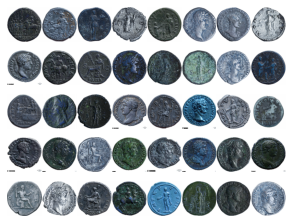

In [3]:
# Display a random set of image data
random.seed(394)
fig = plt.figure(figsize=(5, 4))
for i in range(40):
    ax = fig.add_subplot(5, 8, i+1)
    ax.imshow(cv2.resize(cv2.imread(df['images'][random.randint(1,len(df))]), (128,128)))
    ax.axis('off')
    ax.set_aspect('equal')
    
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

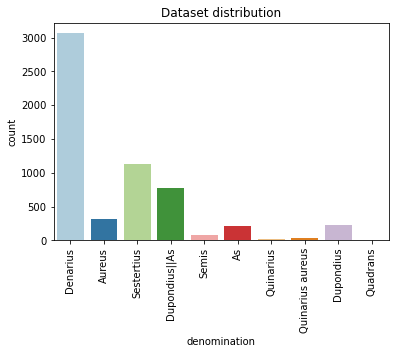

In [4]:
# Visualize dataset distribution
p = sns.countplot(x="denomination", data=df, palette='Paired')
p.set_xticklabels(p.get_xticklabels(), rotation=90)
plt.title('Dataset distribution')
plt.show()

### Train-Test split

In [5]:
# Split dataset into train (75%) and test (25%) sets
train = df.sample(frac=0.75, random_state=394)
test = df.drop(train.index)

### Balance training-set distribution

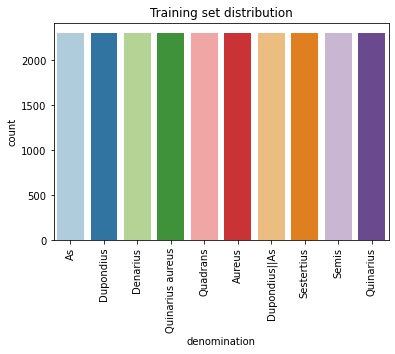

In [6]:
# Resmaple the training set to balance the coin distribution
# This would avoid the class-imbalance problem during training
class_size = max(train['denomination'].value_counts())
train = train.groupby(['denomination']).apply(lambda x: x.sample(class_size, replace=True)).reset_index(drop=True)
train = train.sample(frac=1).reset_index(drop=True)

# Visualize training set distribution
p = sns.countplot(x="denomination", data=train, palette='Paired')
p.set_xticklabels(p.get_xticklabels(), rotation=90)
plt.title('Training set distribution')
plt.show()

In [7]:
# Save split-dataframes to local directory
train.to_csv('../data/Train.csv', index=False)
test.to_csv('../data/Test.csv', index=False)

### Print dataset statistics

In [8]:
# Print the number of examples available per set
print('Training images:', len(train))
print('Test images:', len(test))

Training images: 23000
Test images: 1469


### Create a custom Preprocessing class 

In [9]:
# Define a custom class to preprocess and segment the coin-images
class preprocess(object):
    def __init__(self):
        self.input_image = None
        self.local_range = None

        # Calculate the local image range footprint
        radius = 3
        self._footprint = np.zeros((2*radius+1, 2*radius+1), dtype=np.bool)
        for dx in range(-radius, radius+1):
            for dy in range(-radius, radius+1):
                d_sq = dx*dx + dy*dy
                if d_sq > radius * radius:
                    continue
                self._footprint[dx + radius, dy + radius] = True

    def segment(self, image):
        self.input_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # compute the local range image
        self.local_range = ndi.maximum_filter(self.input_image, footprint=self._footprint)
        self.local_range -= ndi.minimum_filter(self.input_image, footprint=self._footprint)

        # normalize it
        self.local_range = self.local_range / float(np.amax(self.local_range))

        # find a threshold which gives the coin border
        best_threshold = 0
        best_contour = None
        best_form_factor = 0.0
        best_bin_im = None

        for threshold in np.arange(0.05, 0.65, 0.05):
            # Find contours in thresholded image
            contour_im = self.local_range >= threshold
            contours, _ = cv2.findContours(np.array(contour_im, dtype=np.uint8),
                mode=cv2.RETR_EXTERNAL,
                method=cv2.CHAIN_APPROX_NONE)

            # Find maximum area contour
            areas = list(cv2.contourArea(c) for c in contours)
            max_index = np.argmax(areas)

            # Calculate the form factor
            contour = contours[max_index]
            area = areas[max_index]
            perim = cv2.arcLength(contour, closed=True)
            form_factor = 4.0 * np.pi * area / (perim * perim)

            # Reject contours with an area > 90% of the image to reject
            # contour covering entire image
            if area > 0.9 * np.product(self.local_range.shape):
                continue

            # Update best form factor
            if form_factor >= best_form_factor:
                best_threshold = threshold
                best_contour = contour
                best_form_factor = form_factor
                best_bin_im = contour_im

        # Store the extracted edge
        self.edge = np.reshape(best_contour, (len(best_contour), 2))
        self.edge_mask = best_bin_im.astype('float64')
        self.edge_threshold = best_threshold
        self.edge_form_factor = best_form_factor

### Create a DataLoader object to load coin images as torch tensors

In [10]:
class Coins_Dataloader(Dataset):
    def __init__(self, csv_file, transforms):
        # Read filepaths from csv file
        self.Dataset = pd.read_csv(csv_file)

        # Augmentation transforms
        self.transforms = transforms

    def __len__(self):
        # Return total samples in the dataset
        return len(self.Dataset['images'].to_list())

    def __getitem__(self, idx):
        # Image paths and denomination labels
        imagePaths = self.Dataset['images'].to_list()
        labels = self.Dataset['labels'].to_list()

        # Get image path from the current index
        imagePath = imagePaths[idx]

        # Read image from disk in grayscale
        image = cv2.imread(imagePath)

        # Scale the image dimensions
        scale = 512.0 / np.amin(image.shape[0:2])
        image = cv2.resize(image, (int(np.ceil(image.shape[1] * scale)), int(np.ceil(image.shape[0] * scale))))

        # Create preprocessing object
        p = preprocess()

        # Segment the image
        p.segment(image)

        # Get dimensions of the area bounding the coin
        rect = cv2.boundingRect(p.edge)
        x,y,w,h = rect

        # Crop the image within the bounding region
        image = image[y:y+h, x:x+w]

        # Get the associated denomination
        label = labels[idx]

		# Applying transformations, if any
        if self.transforms is not None:
            image = self.transforms(image)

		# Return a tuple of the image and its mask
        return (image, label)

### Build a CGAN Network

In [11]:
# Define a CGANs generator class
class Generator(nn.Module):
    # initializers
    def __init__(self):
        super(Generator, self).__init__()
        self.label_conditioned_generator = nn.Sequential(nn.Embedding(10, 100),
                                                         nn.Linear(100, 16))
        self.latent = nn.Sequential(nn.Linear(100, 4*4*512),
                                    nn.LeakyReLU(0.2, inplace=True))
        self.model = nn.Sequential(nn.ConvTranspose2d(513, 64*8, 4, 2, 1, bias=False),
                                   nn.BatchNorm2d(64*8, momentum=0.1,  eps=0.8),
                                   nn.ReLU(True),
                                   nn.ConvTranspose2d(64*8, 64*4, 4, 2, 1,bias=False),
                                   nn.BatchNorm2d(64*4, momentum=0.1,  eps=0.8),
                                   nn.ReLU(True),
                                   nn.ConvTranspose2d(64*4, 64*2, 4, 2, 1,bias=False),
                                   nn.BatchNorm2d(64*2, momentum=0.1,  eps=0.8),
                                   nn.ReLU(True),
                                   nn.ConvTranspose2d(64*2, 64*1, 4, 2, 1,bias=False),
                                   nn.BatchNorm2d(64*1, momentum=0.1,  eps=0.8),
                                   nn.ReLU(True),
                                   nn.ConvTranspose2d(64*1, 3, 4, 2, 1, bias=False),
                                   nn.Tanh())
    # Forward method
    def forward(self, inputs):
        noise_vector, label = inputs
        label_output = self.label_conditioned_generator(label)
        label_output = label_output.view(-1, 1, 4, 4)
        latent_output = self.latent(noise_vector)
        latent_output = latent_output.view(-1, 512,4,4)
        concat = torch.cat((latent_output, label_output), dim=1)
        image = self.model(concat)

        return image

# Define a CGANs discriminator class
class Discriminator(nn.Module):
    # initializers
    def __init__(self):
        super(Discriminator, self).__init__()
        self.label_condition_disc = nn.Sequential(nn.Embedding(10, 100),
                                                  nn.Linear(100, 3*128*128))
        self.model = nn.Sequential(nn.Conv2d(6, 64, 4, 2, 1, bias=False),
                                   nn.LeakyReLU(0.2, inplace=True),
                                   nn.Conv2d(64, 64*2, 4, 3, 2, bias=False),
                                   nn.BatchNorm2d(64*2, momentum=0.1,  eps=0.8),
                                   nn.LeakyReLU(0.2, inplace=True),
                                   nn.Conv2d(64*2, 64*4, 4, 3,2, bias=False),
                                   nn.BatchNorm2d(64*4, momentum=0.1,  eps=0.8),
                                   nn.LeakyReLU(0.2, inplace=True),
                                   nn.Conv2d(64*4, 64*8, 4, 3, 2, bias=False),
                                   nn.BatchNorm2d(64*8, momentum=0.1,  eps=0.8),
                                   nn.LeakyReLU(0.2, inplace=True),
                                   nn.Flatten(),
                                   nn.Dropout(0.4),
                                   nn.Linear(4608, 1),
                                   nn.Sigmoid())
    # Forward method
    def forward(self, inputs):
        img, label = inputs
        label_output = self.label_condition_disc(label)
        label_output = label_output.view(-1, 3, 128, 128)
        concat = torch.cat((img, label_output), dim=1)
        output = self.model(concat)

        return output

# Define custom weights to be called on generator and discriminator
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        torch.nn.init.normal_(m.weight, 1.0, 0.02)
        torch.nn.init.zeros_(m.bias)

### Define custom plotting functions (to be used in-and-after network training)

In [12]:
def show_images(images):
    fig, ax = plt.subplots(figsize=(20, 20))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images.detach(), nrow=16).permute(1, 2, 0))

def show_batch(dl):
    for images, _ in dl:
        show_images(images)
        break

def performance(H):
    fig = plt.figure(figsize = (8, 6))
    plt.plot(H["D_losses"], label="discriminator_loss")
    plt.plot(H["G_losses"], label="generator_loss")
    plt.title("Model Performance")
    plt.xlabel("Number of epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig('../results/performance.png', dpi=1000, bbox_inches='tight')
    plt.show()

##  Initialize training parameters

In [13]:
# Parameters
num_epochs = 2          ### (Change this to 10)
latent_dim = 100
batch_size = 128
learning_rate = 0.0002
device = "cuda" if torch.cuda.is_available() else "cpu"

# Initialize the cgan network
G = Generator().to(device)
G.apply(weights_init)
D = Discriminator().to(device)
D.apply(weights_init)

# Binary Cross Entropy loss
loss = nn.BCELoss()

# Adam optimizer
G_optimizer = optim.Adam(G.parameters(), lr=learning_rate, betas=(0.5, 0.999))
D_optimizer = optim.Adam(D.parameters(), lr=learning_rate, betas=(0.5, 0.999))

# Initialize a varaible to store training history
training_history = {'D_losses': [],
                    'G_losses': [],
                    'per_epoch_time': []}

## Load training images as torch tensors

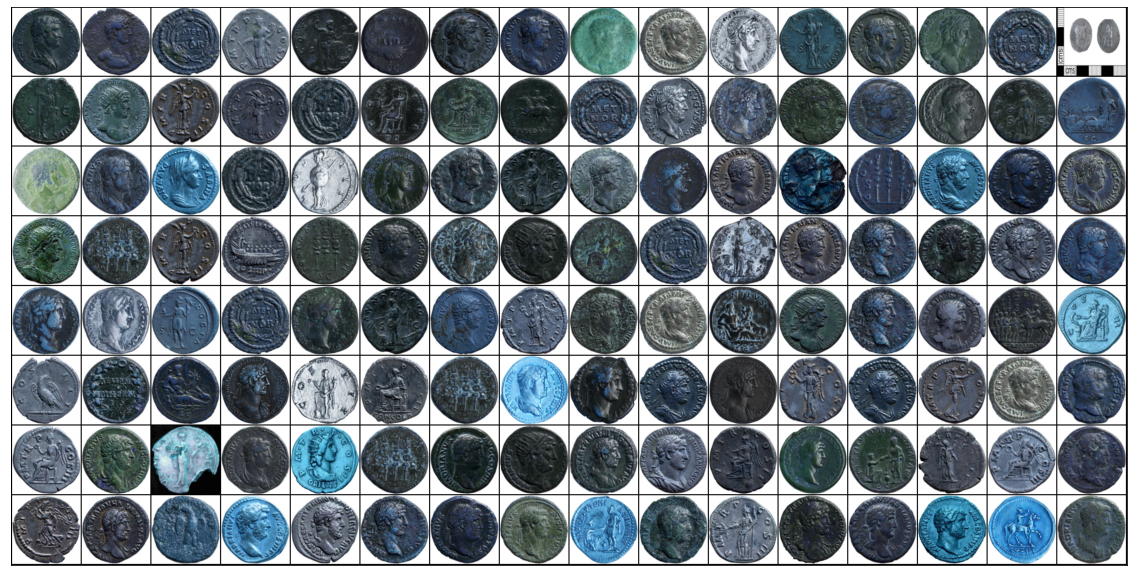

In [14]:
# Define transformations
transform = transforms.Compose([transforms.ToPILImage(),
                                transforms.Resize((128, 128)),
                                transforms.ToTensor()])

# Create training set and load it as torch tensors
TrainDS = Coins_Dataloader(csv_file='../data/Train.csv', transforms=transform)
train_loader = DataLoader(TrainDS,
                          shuffle = True,
                          batch_size = batch_size)

# Show training batch
show_batch(train_loader)

### Network Training

In [15]:
print('Training starts!')
for epoch in range(1, num_epochs+1):
    # Start the timer
    start = time.time()

    # Initialize loss
    discriminator_loss, generator_loss = [], []

    # Loop over the training set
    for index, (real_images, labels) in enumerate(train_loader):
        # Zero out any previously accumulated discriminator gradients
        D_optimizer.zero_grad()

        # Send the input to the device and perform forward pass
        real_images = real_images.to(device)
        label = labels.to(device)
        labels = labels.unsqueeze(1).long().abs()
        real_target = Variable(torch.ones(real_images.size(0), 1).to(device))
        fake_target = Variable(torch.zeros(real_images.size(0), 1).to(device))

        # Compute discriminator loss with real images
        D_real_loss = loss(D((real_images, labels)), real_target)

        # Noise vectors
        noise_vector = torch.randn(real_images.size(0), latent_dim, device=device)
        noise_vector = noise_vector.to(device)

        # Get generated image
        generated_image = G((noise_vector, labels))

        # Train with generated images
        output = D((generated_image.detach(), labels))

        # Compute discriminator loss with generated images
        D_fake_loss = loss(output,  fake_target)

        # Total discriminator loss
        D_total_loss = (D_real_loss + D_fake_loss) / 2
        discriminator_loss.append(D_total_loss)

        # Backward propagate
        D_total_loss.backward()

        # Update discriminator parameters
        D_optimizer.step()

        # Zero out any previously accumulated generator gradients
        G_optimizer.zero_grad()

        # Train generator with real labels and compute total generator loss
        G_loss = loss(D((generated_image, labels)), real_target)
        generator_loss.append(G_loss)

        # Backward propagate
        G_loss.backward()

        # Update generator parameters
        G_optimizer.step()

    # Print iteration information
    print('Epoch: [%d/%d]: D_loss: %.3f | G_loss: %.3f' % ((epoch),
                                                          num_epochs,
                                                          torch.mean(torch.FloatTensor(discriminator_loss)),
                                                          torch.mean(torch.FloatTensor(generator_loss))))

    # Update per epoch losses
    training_history['D_losses'].append(torch.mean(torch.FloatTensor(discriminator_loss)))
    training_history['G_losses'].append(torch.mean(torch.FloatTensor(generator_loss)))

    # Save generated coin images
    save_image(generated_image.data[:50], '../results/generated_images/sample_%d'%epoch + '.png', nrow=batch_size, normalize=True)

    # Save training weights
    torch.save(G.state_dict(), '../results/training_weights/generator_epoch_%d.pth' % (epoch))
    torch.save(D.state_dict(), '../results/training_weights/discriminator_epoch_%d.pth' % (epoch))

    # Stop the timer
    end = time.time()

    # Update per epoch training time
    elapsed = end - start
    training_history['per_epoch_time'].append(time.strftime("%Hh %Mm %Ss", time.gmtime(elapsed)))

print('Training ends!')

Training starts!
Epoch: [1/2]: D_loss: 0.573 | G_loss: 1.237
Epoch: [1/2]: D_loss: 0.425 | G_loss: 0.991
Training ends!


### Network Performance

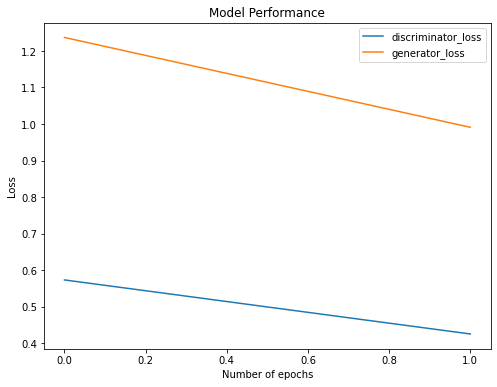

In [16]:
performance(training_history)

### Network Evaluation

In [17]:
# Load test images
TestDS = Coins_Dataloader(csv_file='../data/Test.csv', transforms=transform)
test_loader = DataLoader(TestDS,
                         shuffle = False,
                         batch_size = 128)

In [18]:
# Evaluate the model on test set
print('Evaluating on test images!')
for index, (test_images, labels) in enumerate(test_loader):    
    # Send the input to the device
    test_images = test_images.to(device)
    labels = labels.to(device)
    labels = labels.unsqueeze(1).long().abs()

    # Initialize real and fake target tensors
    real_target = Variable(torch.ones(test_images.size(0), 1).to(device))
    fake_target = Variable(torch.zeros(test_images.size(0), 1).to(device))

    # Compute discriminator loss with test images
    D_test_loss = loss(D((test_images, labels)), real_target)

    # Noise vectors
    noise_vector = torch.randn(test_images.size(0), latent_dim, device=device)
    noise_vector = noise_vector.to(device)

    # Get generated image from test images
    generated_image = G((noise_vector, labels))

    # Test with generated images
    output = D((generated_image.detach(), labels))

    # Compute discriminator loss with generated images
    D_fake_loss = loss(output,  fake_target)

    # Total discriminator loss on test set
    D_loss = (D_test_loss + D_fake_loss) / 2

    # Test generator with real labels and compute total generator loss
    G_loss = loss(D((generated_image, labels)), real_target)

    # Save generated coin images
    save_image(generated_image.data, '../results/generated_images/test_sample_%d'%index + '.png', nrow=12, normalize=True)

    print('Batch: [%d/%d]: D_loss: %.3f | G_loss: %.3f' % ((index),
                                                          len(test_loader)-1,
                                                          D_loss,
                                                          G_loss))

Evaluating on test images!
Batch: [0/11]: D_loss: 0.687 | G_loss: 0.693
Batch: [1/11]: D_loss: 0.687 | G_loss: 0.693
Batch: [2/11]: D_loss: 0.687 | G_loss: 0.693
Batch: [3/11]: D_loss: 0.687 | G_loss: 0.693
Batch: [4/11]: D_loss: 0.687 | G_loss: 0.693
Batch: [5/11]: D_loss: 0.687 | G_loss: 0.693
Batch: [6/11]: D_loss: 0.687 | G_loss: 0.693
Batch: [7/11]: D_loss: 0.687 | G_loss: 0.693
Batch: [8/11]: D_loss: 0.687 | G_loss: 0.693
Batch: [9/11]: D_loss: 0.687 | G_loss: 0.693
Batch: [10/11]: D_loss: 0.687 | G_loss: 0.693
Batch: [11/11]: D_loss: 0.687 | G_loss: 0.693


**Check *../results/generated_images/* directory to view the reconstructed coins**